### Creating Prediction Value ( Adding Labels)
We are using a 7 (trading) days prediction interval. Thus, the idea is to observe the technical indicators for today and use it to predict the direction of movement of the stocks 7 days later. If the stock went up in 7 days, we denote it by 1 and if it went down/did not change, we denote it by 0 (“Target_Direction”)

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import pickle
from scipy.stats import mstats
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
Target_variables = ['SMA','k','d','RSI','MACD']
train_start = '2013-01-02'
test_start = '2017-01-01'


In [3]:
rf = RandomForestClassifier()

In [4]:
Amazon = pd.read_csv('Amazon.csv')
Apple = pd.read_csv('Apple.csv')
Google = pd.read_csv('Google.csv')
Microsoft = pd.read_csv('Microsoft.csv')


In [5]:
def create_prediction_value(df):
    df['Close_Shifted'] = df['Adj Close'].transform(lambda x: x.shift(-6))
    df['Target'] = ((df['Close_Shifted'] - df['Open'])/(df['Open']) * 100).shift(-1)
    df['Target_Direction'] = np.where(df['Target']>0,1,0)
    df = df.dropna().copy()
    return df

In [6]:
Amazon = create_prediction_value(Amazon)
Apple = create_prediction_value(Apple)
Google = create_prediction_value(Google)
Microsoft = create_prediction_value(Microsoft)

In [7]:
Amazon.head()

,Date,High,Low,Open,Close,Volume,Adj Close,SMA,MACD,k,d,RSI,Close_Shifted,Target,Target_Direction
0,2013-01-02,258.100006,253.259995,256.079987,257.309998,3271000,257.309998,253.498665,0.634111,71.512810,60.902685,57.082746,265.339996,4.147399,1
1,2013-01-03,260.880005,256.369995,257.269989,258.480011,2750900,258.480011,254.017999,0.660732,77.259442,62.884793,58.505474,267.940002,5.881678,1
2,2013-01-04,259.799988,256.649994,257.579987,259.149994,1874200,259.149994,254.510666,0.757346,80.550126,76.440792,59.336758,272.730011,3.395822,1
3,2013-01-07,269.730011,262.670013,262.970001,268.459991,4910000,268.459991,255.657999,1.039575,95.292739,84.367436,68.715731,271.899994,0.696441,1
4,2013-01-08,268.980011,263.570007,267.070007,266.380005,3010700,266.380005,256.803999,1.387794,87.583378,87.808748,65.102887,268.929993,0.861393,1


In [8]:
Amazon['Target_Direction'].value_counts()

1    878
0    625
Name: Target_Direction, dtype: int64

In [9]:
def winsorise(df):
    for variable in Target_variables:
        df.loc[:,variable] = mstats.winsorize(df.loc[:,variable], limits = [0.1,0.1])
    return df

In [10]:
Amazon = winsorise(Amazon)
Apple = winsorise(Apple)
Google = winsorise(Google)
Microsoft = winsorise(Microsoft)

In [11]:
Amazon.set_index('Date', inplace = True)
Apple.set_index('Date', inplace = True)
Google.set_index('Date', inplace = True)
Microsoft.set_index('Date', inplace = True)

In [12]:
def change_to_time_index(df):
    df.index = pd.to_datetime(df.index)
    return df

In [13]:
Amazon = change_to_time_index(Amazon)
Apple = change_to_time_index(Apple)
Google = change_to_time_index(Google)
Microsoft = change_to_time_index(Microsoft)

In [14]:
def get_train_test_data(df):
    train_data = df.loc[:test_start]
    test_data = df.loc[test_start:] 
    return train_data, test_data

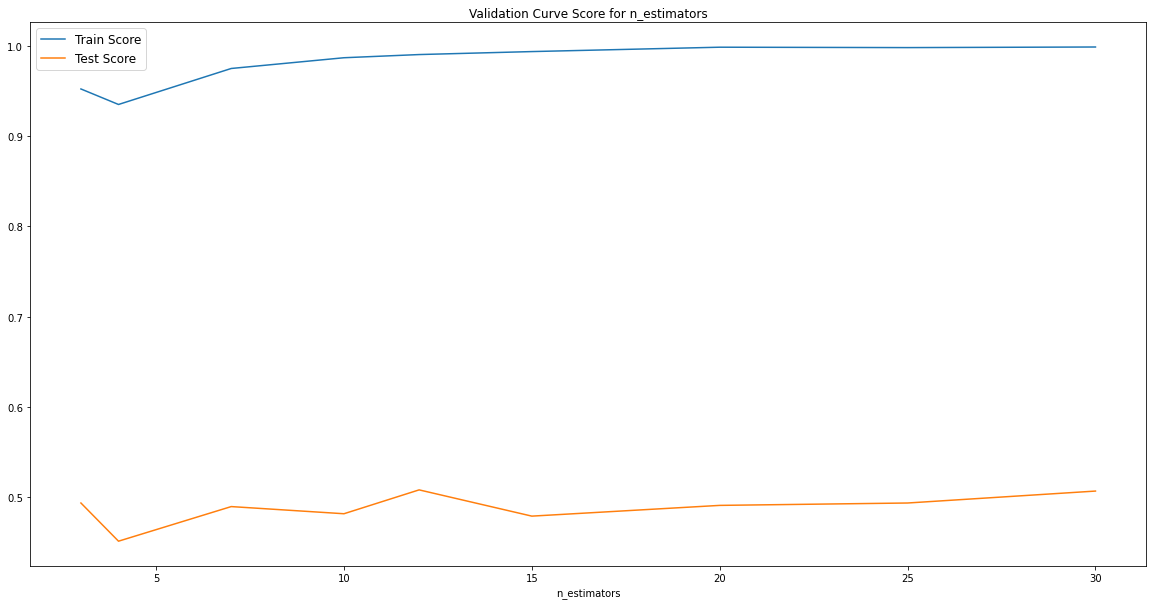

In [19]:
def get_validation_curve(df):
    train_data, test_data = get_train_test_data(df)
    X_train = train_data.loc[:,Target_variables]
    Y_train = train_data.loc[:,['Target_Direction']]
    train_scoreNum, test_scoreNum = validation_curve(rf,
                                    X = X_train[train_start:], y = Y_train.loc[train_start:,'Target_Direction'], 
                                    param_name = 'n_estimators', 
                                    param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

    train_scores_mean = np.mean(train_scoreNum, axis=1)
    train_scores_std = np.std(train_scoreNum, axis=1)
    test_scores_mean = np.mean(test_scoreNum, axis=1)
    test_scores_std = np.std(test_scoreNum, axis=1)

    plt.figure(figsize = (20,10))
    plt.plot([3,4,7,10,12,15,20,25,30],train_scores_mean)
    plt.plot([3,4,7,10,12,15,20,25,30],test_scores_mean)
    plt.legend(['Train Score','Test Score'], fontsize = 'large')
    plt.title('Validation Curve Score for n_estimators', fontsize = 'large')
    plt.xlabel('n_estimators')
    
get_validation_curve(Amazon)


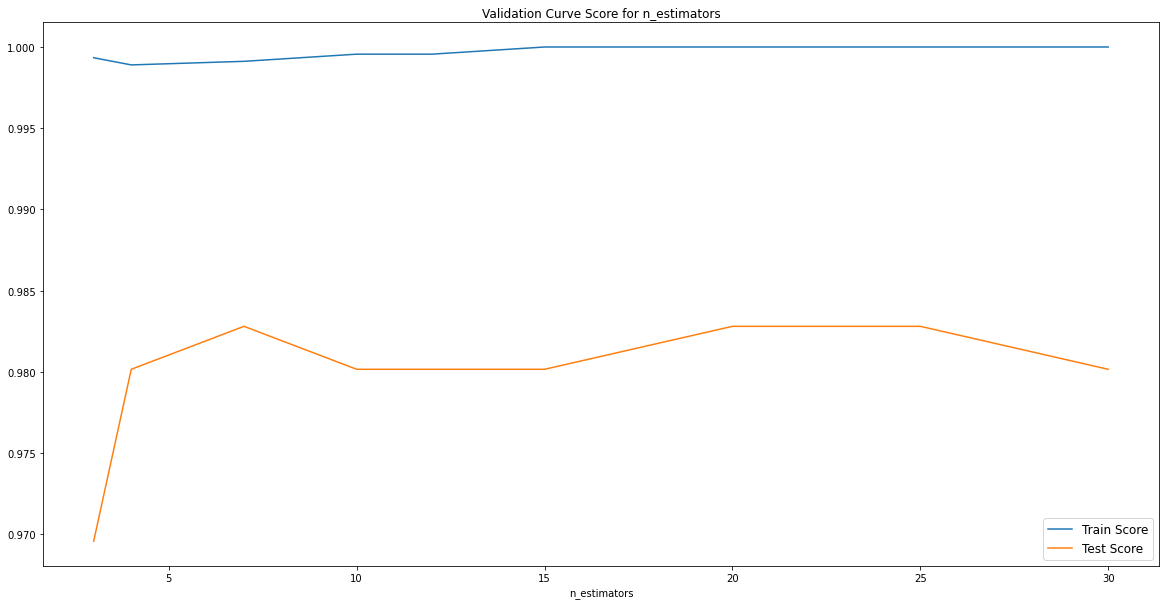

In [20]:
get_validation_curve(Apple)

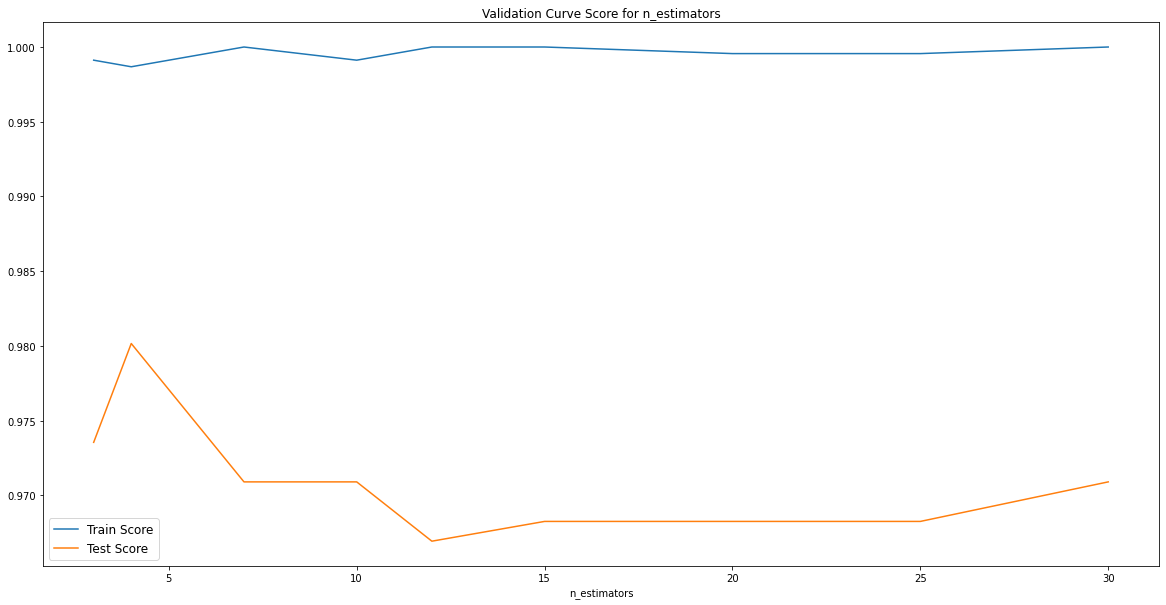

In [21]:
get_validation_curve(Microsoft)

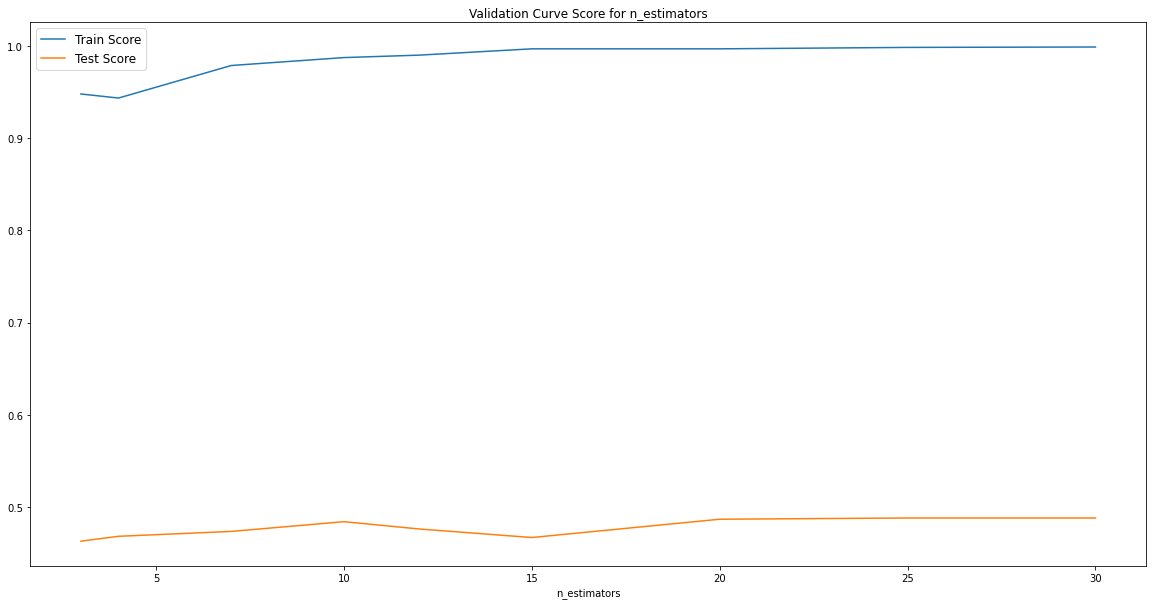

In [22]:
get_validation_curve(Google)

In [23]:
# parameters using validation curves 
amazon_params = { 'max_depth':[5, 7],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [10, 15, 20],
                  'n_estimators': [7, 9, 11, 13],
                  'min_samples_split':[20, 25, 30]}

apple_params = { 'max_depth':[5, 7],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [10, 15, 20],
                  'n_estimators': [5, 7, 9, 10, 11],
                  'min_samples_split':[20, 25, 30]}

google_params = { 'max_depth':[5, 7],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [10, 15, 20],
                  'n_estimators': [2, 3, 5, 7],
                  'min_samples_split':[20, 25, 30]}

microsoft_params = { 'max_depth':[5, 7],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [10, 15, 20],
                  'n_estimators': [3, 4, 5, 7],
                  'min_samples_split':[20, 25, 30]}


In [24]:
def train_predict(df, params, stock_name):
    co_train = df[:test_start]
    co_train = co_train.dropna().copy()
    co_test = df[test_start:]
    co_test = co_test.dropna().copy()


    X_train = co_train.loc[:,Target_variables]
    Y_train = co_train.loc[:,['Target_Direction']]

    X_test = co_test.loc[:, Target_variables]
    Y_test = co_train.loc[:,['Target_Direction']]


    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)


    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 20)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train)
    test_pred = rf_cv.predict(X_test)
    total_pred = rf_cv.predict(df.loc[:,Target_variables])

    #Save the fited variable into a Pickle file
    # file_loc = f'{os.getcwd()}\\Pickle_Files\\Amazon' 
    file_name = stock_name +"_trend"
    pickle.dump(rf_cv, open(file_name,'wb'))
    return test_pred, total_pred 


In [25]:
def get_accuracy(df, test_pred):    
    y_test = df[test_start:]
    co_test = y_test.dropna().copy()
    Y_test = co_test.loc[:,['Target_Direction']]
    return accuracy_score(test_pred, Y_test )

In [28]:
test_pred, total_pred = train_predict(Amazon, amazon_params, "amazon")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [29]:
get_accuracy(Amazon, test_pred)

0.5070707070707071

In [31]:
test_pred_apple, total_pred_apple = train_predict(Apple, apple_params, "apple")

Fitting 3 folds for each of 90 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [32]:
get_accuracy(Apple, test_pred_apple)

0.8606060606060606

In [33]:
test_pred_google, total_pred_google = train_predict(Google, google_params, "google")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [34]:
get_accuracy(Google, test_pred_google)

0.49696969696969695

In [35]:
test_pred_microsoft, total_pred_microsoft = train_predict(Microsoft, microsoft_params, "microsoft")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [36]:
get_accuracy(Microsoft, test_pred_microsoft)

0.9090909090909091

In [37]:
Amazon['Predicted Trend'] = total_pred
Apple['Predicted Trend'] = total_pred_apple
Google['Prediicted Trend'] = total_pred_google
Microsoft['Predicted Trend'] = total_pred_microsoft

In [38]:
Amazon.head()

,High,Low,Open,Close,Volume,Adj Close,SMA,MACD,k,d,RSI,Close_Shifted,Target,Target_Direction,Predicted Trend
Date,,,,,,,,,,,,,,,
2013-01-02,258.100006,253.259995,256.079987,257.309998,3271000,257.309998,291.908665,0.634111,71.512810,60.902685,57.082746,265.339996,4.147399,1,1
2013-01-03,260.880005,256.369995,257.269989,258.480011,2750900,258.480011,291.908665,0.660732,77.259442,62.884793,58.505474,267.940002,5.881678,1,1
2013-01-04,259.799988,256.649994,257.579987,259.149994,1874200,259.149994,291.908665,0.757346,80.550126,76.440792,59.336758,272.730011,3.395822,1,1
2013-01-07,269.730011,262.670013,262.970001,268.459991,4910000,268.459991,291.908665,1.039575,95.292739,84.367436,68.715731,271.899994,0.696441,1,1
2013-01-08,268.980011,263.570007,267.070007,266.380005,3010700,266.380005,291.908665,1.387794,87.583378,87.808748,65.102887,268.929993,0.861393,1,1


In [39]:
Amazon.to_csv('Amazon_with_trend.csv')
Apple.to_csv('Apple_with_trend.csv')
Google.to_csv('Google_with_trend.csv')
Microsoft.to_csv('Microsoft_with_trend.csv')

In [40]:
ls

Amazon.csv
Amazon_all.csv
Amazon_with_trend.csv
Apple.csv
Apple_all.csv
Apple_with_trend.csv
Bot.ipynb
Bot.ipynb copy
Bot_old.ipynb
Bot_stock Data.ipynb
Combine all the data.ipynb
Combined_data.csv
Data Collection and Preprocessing.ipynb
Ensemble Test-Copy1.ipynb
Ensemble Test.ipynb
Google.csv
Google_all.csv
Google_with_trend.csv
Market Trend Prediction.ipynb
Microsoft.csv
Microsoft_all.csv
Microsoft_with_trend.csv
Multi Company RL Bot for Stock Data .ipynb
New MDP for Amazon/
RL bot for combined data-multi company.ipynb
Sentiment Analysis.ipynb
Stock_senti_trend.ipynb
Web app/
Web app.zip
Web-app sentiment.ipynb
amazon
amazonSentiments.csv
amazon_trend
amzn_aapl_goog_msft.csv
appleSentiments.csv
apple_trend
bot2 copy.py
data .ipynb
googleSentiments.csv
google_trend
microsoftSentiments.csv
microsoft_trend
tweets.json
tweets_apple.json
tweets_google.json


In [43]:
def train_predict(df):
    co_train = df[:test_start]
    co_train = co_train.dropna().copy()
    co_test = df[test_start:]
    co_test = co_test.dropna().copy()


    X_train = co_train.loc[:,Target_variables]
    Y_train = co_train.loc[:,['Target_Direction']]

    X_test = co_test.loc[:, Target_variables]
    Y_test = co_train.loc[:,['Target_Direction']]
    return X_train

In [44]:
train_predict(Amazon)

,SMA,k,d,RSI,MACD
Date,,,,,
2013-01-02,291.908665,71.512810,60.902685,57.082746,0.634111
2013-01-03,291.908665,77.259442,62.884793,58.505474,0.660732
2013-01-04,291.908665,80.550126,76.440792,59.336758,0.757346
2013-01-07,291.908665,95.292739,84.367436,68.715731,1.039575
2013-01-08,291.908665,87.583378,87.808748,65.102887,1.387794
...,...,...,...,...,...
2016-12-23,765.819332,23.155382,52.465223,46.555675,-2.684589
2016-12-27,766.622001,61.138478,48.150692,52.099080,-2.351431
2016-12-28,767.116003,63.703411,49.332424,52.457693,-1.973711


In [50]:
at = pickle.load(open("amazon_trend", "rb"))

In [ ]:
at.predict()